### Aggregating all topics ->  Exploring results -> Calculating coherence -> Conducting statistical analysis with coherence scores

In [165]:
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import csv
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import f_oneway



In [ ]:
#Note that this data was manually gathered from all the different outputs of all the different models 
df = pd.read_csv('aggregated_topics.csv')
df.head()


## Exploration 

In [145]:
topic_counts = df['Topic'].value_counts()
print(topic_counts)


Topic
Customer Service & Friendliness    17
Assortment                         10
Store Layout                        7
Store Experience                    6
Waiting Times                       3
Quality and Value Proposition       3
Staff Knowledge                     3
Product Quality                     3
COVID-19 Measures                   3
Online Shopping and Ordering        2
Accessibility                       2
Cashier                             2
Advice                              2
Product Availability                2
Women’s Shoes Size                  1
Gifts and Gift Cards                1
Shoes                               1
Staffing Issues                     1
Value Proposition                   1
Post-Office Services                1
Shopping Experience                 1
Advice & Helpfulness                1
Wait Times and Service Speed        1
Staff                               1
Purchase Experience                 1
Parking                             1
Paint 

In [ ]:
# Word Cloud for topic labels
text = ' '.join(df['Topic'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
###
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Topic Labels')
plt.show()


In [ ]:
# Number of topics per retailer per model
topic_counts = df.groupby(['Retailer', 'Model']).size().reset_index(name='Counts')
#####
plt.figure(figsize=(14, 8))
sns.barplot(data=topic_counts, x='Retailer', y='Counts', hue='Model')
plt.title('Number of Topics Across Retailers and Models')
plt.xlabel('Retailer')
plt.ylabel('Number of Topics')
plt.legend(title='Model')
plt.show()


In [ ]:
#Network graphs to visually demonstrate the relationship between the models and the resulting topics and how they may intertwine 
data = df
grouped_data = data.groupby(['Retailer', 'Model', 'Topic']).size().reset_index(name='Count')
retailers = grouped_data['Retailer'].unique()
############
for retailer in retailers:
    retailer_data = grouped_data[grouped_data['Retailer'] == retailer]
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges to the graph
    for _, row in retailer_data.iterrows():
        model_node = row['Model']
        topic_node = row['Topic']
        G.add_edge(model_node, topic_node, weight=row['Count'])
    
    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.3)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='orange')
    nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    plt.title(f'Network Graph of Models and Topics for Retailer: {retailer}', fontsize=20)
    plt.axis('off')
    plt.show()



## Calculating Coherence Scores

This process was conducted in my local terminal as I needed to install the necessary programs to run the Palmetto measures localy. 

In [51]:
### Extract keywords to a text file 
keywords = df['Keywords']
keywords.to_csv('Keywords.txt', index=False, header=False)

"""
cd "C:\Users\fares\OneDrive\Desktop\Palmetto"
java -jar palmetto-0.1.0-jar-with-dependencies.jar "C:/Users/fares/OneDrive/Desktop/Palmetto/nlwiki-palmetto" C_V "C:/Users/fares/OneDrive/Desktop/Palmetto/Keywords.txt" > "C:/Users/fares/OneDrive/Desktop/Palmetto/CV.txt"
java -jar palmetto-0.1.0-jar-with-dependencies.jar "C:/Users/fares/OneDrive/Desktop/Palmetto/nlwiki-palmetto" C_A "C:/Users/fares/OneDrive/Desktop/Palmetto/Keywords.txt" > "C:/Users/fares/OneDrive/Desktop/Palmetto/CA.txt"

"""

Now I Merge the resulting text files with the dataframe of the topic mappings

In [ ]:
##### Merge both score files into a csv ####
file_path_ca = 'CA.txt'
file_path_cv = 'CV.txt'

with open(file_path_ca, 'r') as file_ca:
    file_content_ca = file_ca.read()

with open(file_path_cv, 'r') as file_cv:
    file_content_cv = file_cv.read()

# 
lines_ca = file_content_ca.splitlines()
lines_cv = file_content_cv.splitlines()

# 
merged_content = {}

# 
for line in lines_ca:
    index, value, words = line.split(',', 2)
    merged_content[index] = [value, words]

for line in lines_cv:
    index, value, words = line.split(',', 2)
    if index in merged_content:
        merged_content[index].extend([value, words])
    else:
        merged_content[index] = [value, words]

#
output_path = 'CA_CV.csv'

with open(output_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write the header row
    csvwriter.writerow(['Index', 'Value_CA', 'Words_CA', 'Value_CV', 'Words_CV'])
    # Write the merged content
    for index, values in merged_content.items():
        row = [index] + values
        csvwriter.writerow(row)




In [ ]:
###Merge score with aggregated topics 
result = pd.read_csv('CA_CV.csv')
result.drop(columns=['Words_CV', 'Words_CA'], inplace= True)

#####merge
df = pd.merge(result, df, left_index=True, right_index=True, how='outer')

# drop unwanted cols
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#order my cols for visual ease
columns_order = [col for col in df.columns if col not in ['Value_CA', 'Value_CV']] + ['Value_CA', 'Value_CV']
df = df[columns_order]

# save to csv
output_path = 'FINAL.csv'
df.to_csv(output_path, index=False)



### Intial Exploration of the Results
Now that we have the topics for each model and retailer and their associate coherence scores, we will move on to do some exploration and then conduct a statistical test

In [152]:
df = pd.read_csv('FINAL.csv')
df.head()

,Index,Retailer,Model,Topic,Keywords,Value_CA,Value_CV
0,0,R1,BERT + GPT,Customer Service & Friendliness,"vriendelijk , behulpzam , sociaal , medewerker...",0.08688,0.51913
1,1,R1,BERT + GPT,Store Experience,"winkel , parker , rommel , poortj , asfalter ,...",0.05243,0.63990
2,2,R1,BERT + GPT,Assortment,"assortiment , aanbied , voorrad , artikel , pe...",0.22580,0.36342
3,3,R1,BERT + GPT,Home Improvement Products,"assortiment , prijz , ijzerwar , schroev , moe...",0.50000,0.25000
4,4,R1,BERT + GPT,Customer Service & Friendliness,"geholp , tevred , toekomst , tip , verker , ad...",0.18615,0.45037


C:\Users\fares\AppData\Local\Temp\ipykernel_15104\553384508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[0], x='Model', y='Value_CA', data=df, inner='box', scale='width', palette=violin_colors)
C:\Users\fares\AppData\Local\Temp\ipykernel_15104\553384508.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(ax=axes[0], x='Model', y='Value_CA', data=df, inner='box', scale='width', palette=violin_colors)
C:\Users\fares\AppData\Local\Temp\ipykernel_15104\553384508.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[1], x='Model', y='Value_CV', data=df, inner='

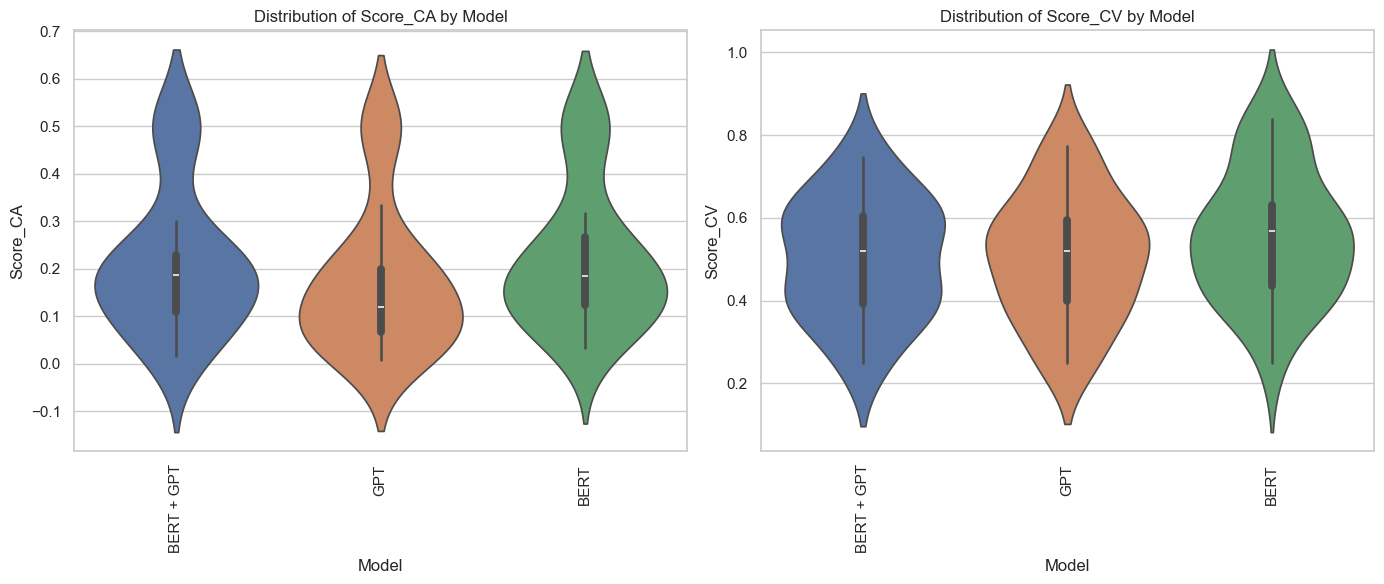

In [153]:
#### Violin Plot
sns.set(style="whitegrid")
#
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# 
violin_colors = ["#4c72b0", "#dd8452", "#55a868"]
#
sns.violinplot(ax=axes[0], x='Model', y='Value_CA', data=df, inner='box', scale='width', palette=violin_colors)
axes[0].set_title('Distribution of Score_CA by Model')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score_CA')
axes[0].tick_params(axis='x', rotation=90)
# 
sns.violinplot(ax=axes[1], x='Model', y='Value_CV', data=df, inner='box', scale='width', palette=violin_colors)
axes[1].set_title('Distribution of Score_CV by Model')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score_CV')
axes[1].tick_params(axis='x', rotation=90)

# 
plt.tight_layout()
plt.show()


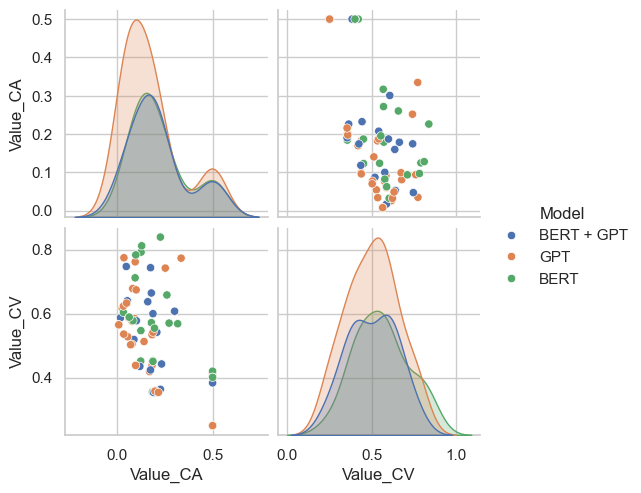

In [122]:
sns.pairplot(df[['Value_CA', 'Value_CV', 'Model']], hue='Model')
plt.show()


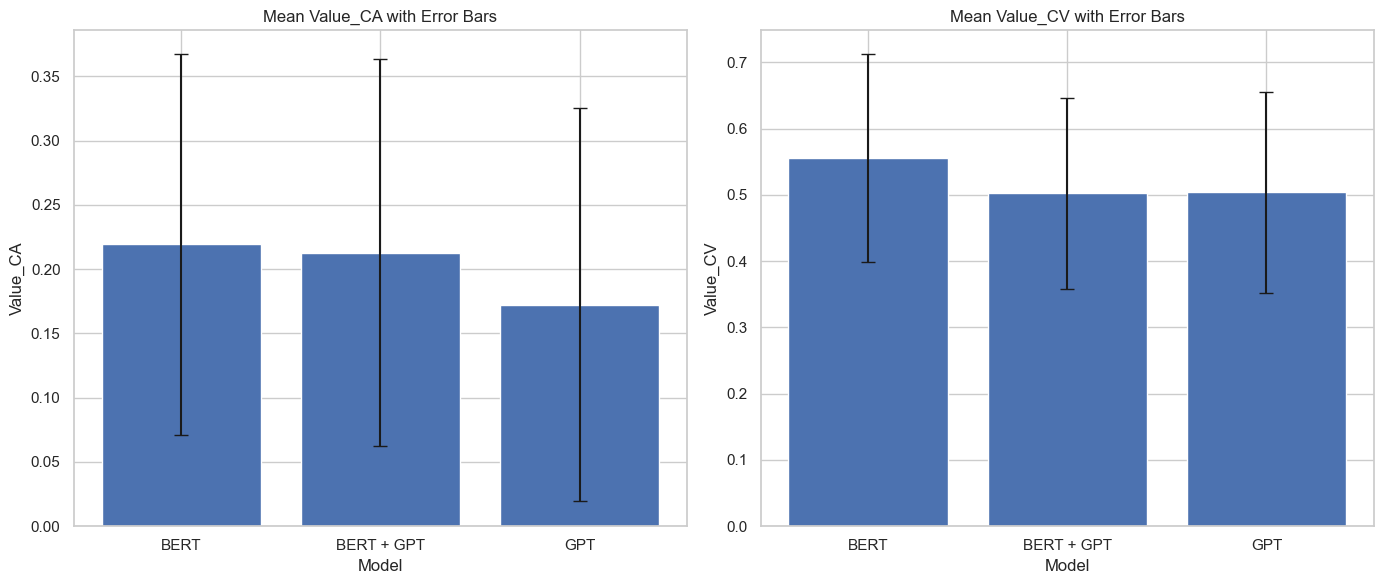

In [123]:
# Calculate mean and standard deviation for each model
mean_std = df.groupby('Model')[['Value_CA', 'Value_CV']].agg(['mean', 'std']).reset_index()

# Plot the means with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for Value_CA
axes[0].bar(mean_std['Model'], mean_std['Value_CA']['mean'], yerr=mean_std['Value_CA']['std'], capsize=5)
axes[0].set_title('Mean Value_CA with Error Bars')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Value_CA')

# Bar plot for Value_CV
axes[1].bar(mean_std['Model'], mean_std['Value_CV']['mean'], yerr=mean_std['Value_CV']['std'], capsize=5)
axes[1].set_title('Mean Value_CV with Error Bars')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Value_CV')

plt.tight_layout()
plt.show()


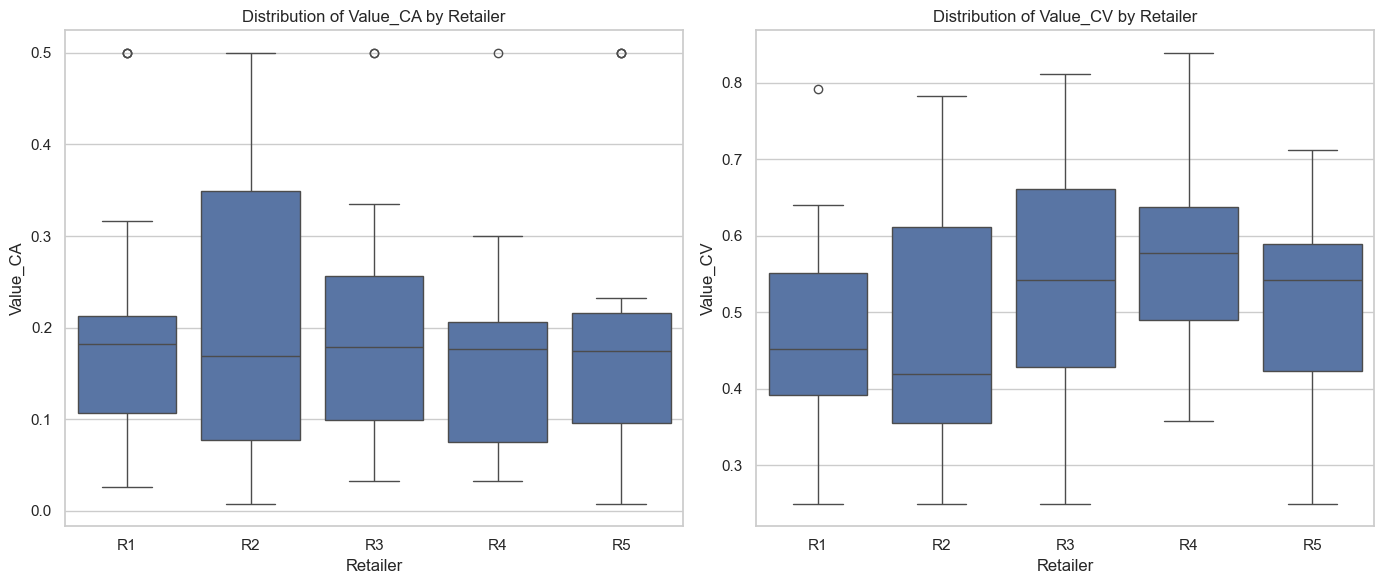

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style of the plots
sns.set(style="whitegrid")

# Create a figure with two subplots: one for Value_CA and one for Value_CV
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for Value_CA by Retailer
sns.boxplot(ax=axes[0], x='Retailer', y='Value_CA', data=df)
axes[0].set_title('Distribution of Value_CA by Retailer')
axes[0].set_xlabel('Retailer')
axes[0].set_ylabel('Value_CA')

# Boxplot for Value_CV by Retailer
sns.boxplot(ax=axes[1], x='Retailer', y='Value_CV', data=df)
axes[1].set_title('Distribution of Value_CV by Retailer')
axes[1].set_xlabel('Retailer')
axes[1].set_ylabel('Value_CV')

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\fares\AppData\Local\Temp\ipykernel_15104\1193525415.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(ax=axes[0], x='Model', y='Value_CA', hue='Retailer', data=df, split=True, inner='box', scale='width')
C:\Users\fares\AppData\Local\Temp\ipykernel_15104\1193525415.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(ax=axes[1], x='Model', y='Value_CV', hue='Retailer', data=df, split=True, inner='box', scale='width')


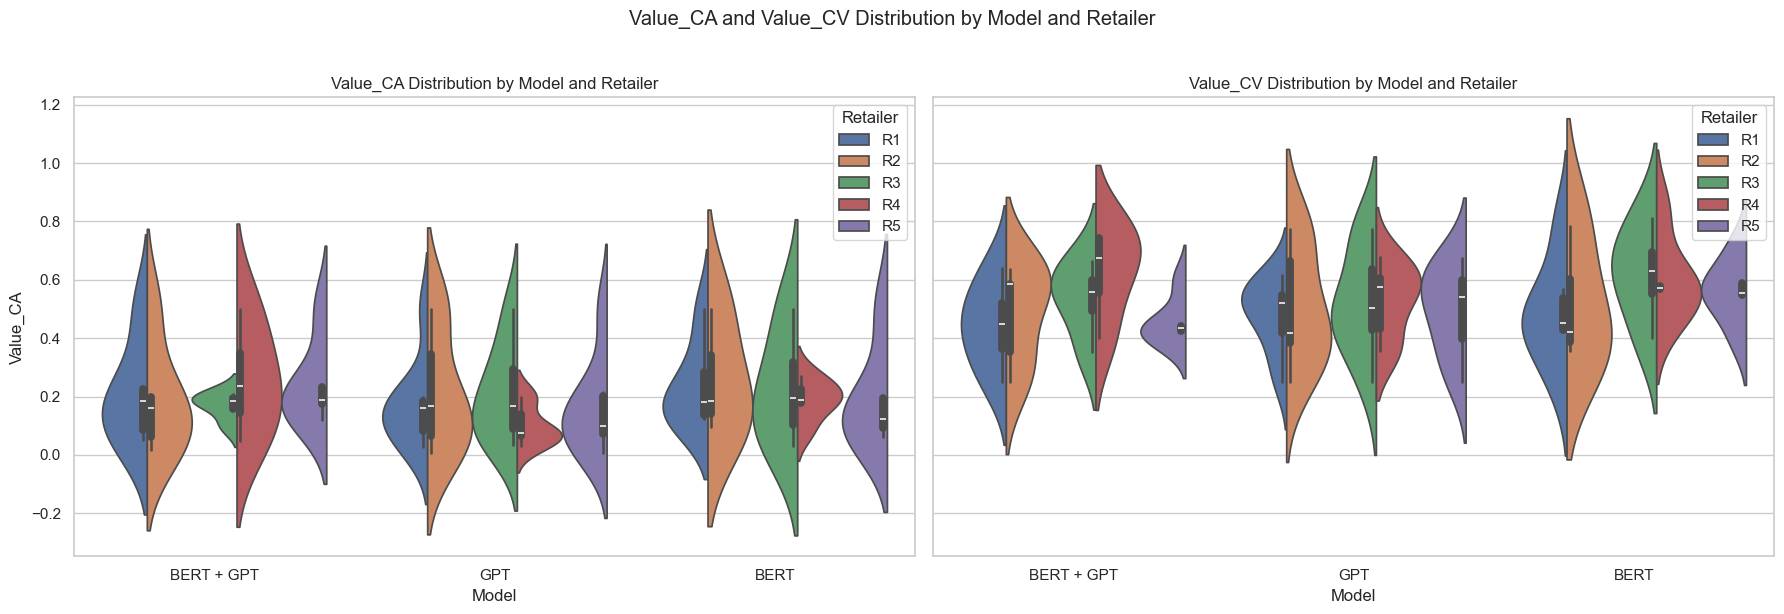

In [127]:
# Create a figure for violin plots for Value_CA by Model and Retailer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)
fig.suptitle('Value_CA and Value_CV Distribution by Model and Retailer', y=1.02)

# Violin plot for Value_CA
sns.violinplot(ax=axes[0], x='Model', y='Value_CA', hue='Retailer', data=df, split=True, inner='box', scale='width')
axes[0].set_title('Value_CA Distribution by Model and Retailer')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Value_CA')

# Violin plot for Value_CV
sns.violinplot(ax=axes[1], x='Model', y='Value_CV', hue='Retailer', data=df, split=True, inner='box', scale='width')
axes[1].set_title('Value_CV Distribution by Model and Retailer')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Value_CV')

plt.tight_layout()
plt.show()


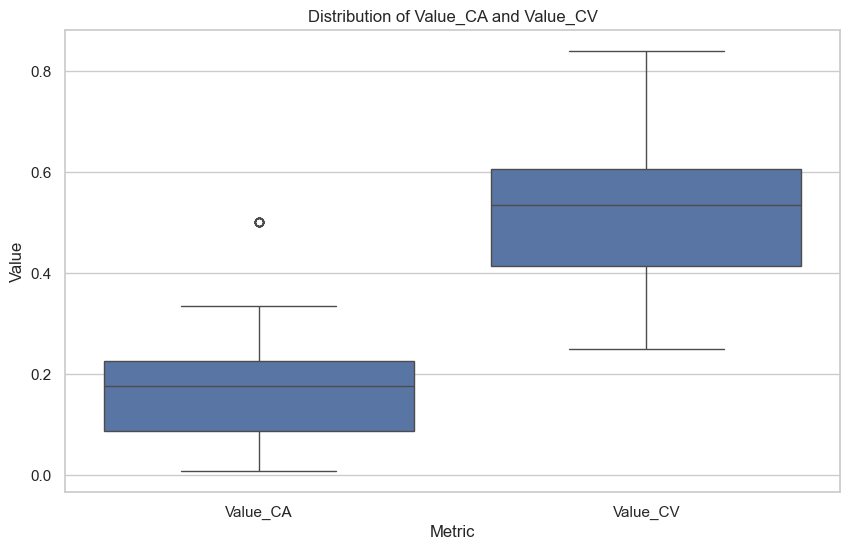

In [130]:
df_melted = df.melt(value_vars=['Value_CA', 'Value_CV'], var_name='Metric', value_name='Value')

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=df_melted)
plt.title('Distribution of Value_CA and Value_CV')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()


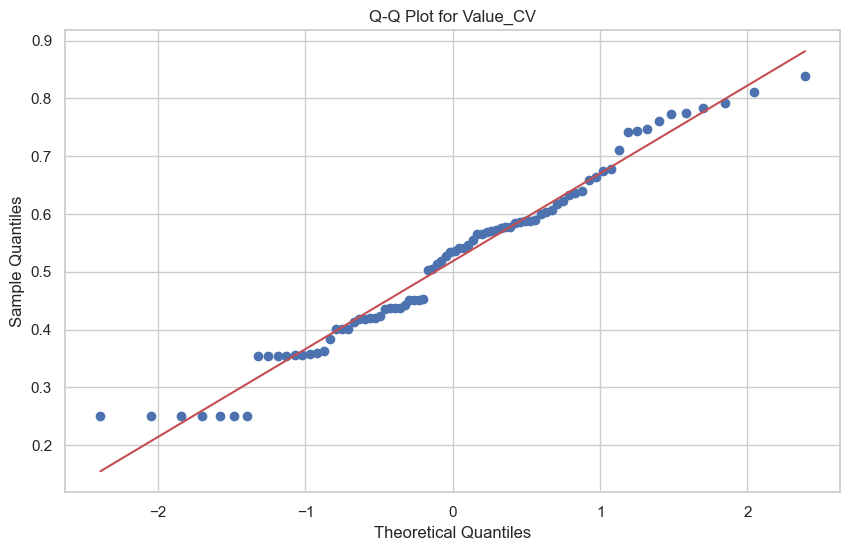

In [134]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Create a Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(df['Value_CV'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Value_CV')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


### Normality test

In [162]:
####Shapiro-Wilk test
results = {}
for score in ['Value_CA', 'Value_CV']:
    for model in df['Model'].unique():
        subset = df[df['Model'] == model][score]
        stat, p_value = shapiro(subset)
        results[f'{model} - {score}'] = {'W-Statistic': stat, 'p-value': p_value}
#####

results_df = pd.DataFrame(results).T
print(results_df)

                       W-Statistic   p-value
BERT + GPT - Value_CA     0.839303  0.001751
GPT - Value_CA            0.811171  0.000027
BERT - Value_CA           0.839685  0.001779
BERT + GPT - Value_CV     0.958929  0.442082
GPT - Value_CV            0.961562  0.240092
BERT - Value_CV           0.956265  0.392241


### Kruskal-Wallis Test 

In [164]:
#######
Value_ca_bert_gpt = df[df['Model'] == 'BERT + GPT']['Value_CA']
Value_ca_gpt = df[df['Model'] == 'GPT']['Value_CA']
Value_ca_bert = df[df['Model'] == 'BERT']['Value_CA']
#
kruskal_result_ca = kruskal(Value_ca_bert_gpt, Value_ca_gpt, Value_ca_bert)



kruskal_result_ca

KruskalResult(statistic=3.1967061707631417, pvalue=0.20222929827668895)

### ANOVA test

In [169]:
######
Value_cv_bert_gpt = df[df['Model'] == 'BERT + GPT']['Value_CV']
Value_cv_gpt = df[df['Model'] == 'GPT']['Value_CV']
Value_cv_bert = df[df['Model'] == 'BERT']['Value_CV']
# 
anova_stat, anova_p_value = f_oneway(Value_cv_bert_gpt, Value_cv_gpt, Value_cv_bert)

print(anova_stat, anova_p_value)

0.9787917824276795 0.3802746738289894
